In [1]:
%matplotlib widget
from ipywidgets import interact, fixed, interact_manual
from typing import Tuple

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'size': 14}

matplotlib.rc('font', **font)

## Gaussian Distributions

Alex Gorodetsky, January 23, 2024

A $n$-dimensional random variable $X \sim \mathcal{N}(\mu, \Sigma)$ that is distributed according to a multivariate Gaussian distribution with mean $\mu \in \mathbb{R}^{n} $ and covariance (positive definite) $\Sigma \in \mathbb{R}^{n \times n}$ has the following probability density function

\begin{align}
f*X(x; \mu, \Sigma) &= \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}\exp \left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right) \\
&= \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} \exp\left( - \frac{1}{2} \lVert x - \mu \rVert*{\Sigma}^2\right)
\end{align}
where $|\Sigma|$ denotes the determinant of the covariance matrix and the norm is defined as

\begin{equation}
\lVert y \rVert\_{\Sigma} = \sqrt{y^T \Sigma^{-1}y}.
\end{equation}


In [3]:
def normpdf(x: np.ndarray, mean: np.ndarray, cov: np.ndarray) -> np.ndarray:
    """PDF of a Multivariate Gaussian Random Variable.

    Args:
        x: (n, N) array of locations at which to evaluate the pdf
        mean: (n) array denoting the mean
        cov: (n, n) array denoting the covariance

    Returns:
        out: (N) array of pdf at each input x
    """
    n, N = x.shape

    # Compute the pre-exponential factor
    preexp = 1.0 / (2.0 * np.pi)**(n/2) / np.linalg.det(cov)**0.5

    # Compute the difference between the inputs x and the mean
    # This difference has size n X N
    diff = x - np.tile(mean[:, np.newaxis], (1, N))

    # We now need to compute
    # Compute sol = \Sigma^{-1} diff, sol is now n X N (Sigma * sol = diff)
    sol = np.linalg.solve(cov, diff)

    # we now need to take the dot product of each column of diff and sol
    # equivalent of the below (but much much much faster for large N)
    # for ii in range(N):
    #     inexp[ii] = np.dot(diff[:, ii], sol[:, ii])
    inexp = np.einsum("ij, ij->j", diff, sol)

    out = preexp * np.exp(-0.5 * inexp)
    return out

Lets look at what a one dimensional Gaussian looks like


In [4]:
@interact(std=(1e-10, 10))
def plot1d(std):
    x = np.linspace(-10, 10, 100000)
    mean = np.array([0.0])
    cov = np.array([[std*std]])
    pdf_vals = normpdf(x[np.newaxis, :], mean, cov)
    plt.close(1)
    plt.figure(1)
    plt.plot(x, pdf_vals, '-')
    plt.grid(which='both')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$f_X(x)$')
    plt.show()

interactive(children=(FloatSlider(value=5.00000000005, description='std', max=10.0, min=1e-10), Output()), _do…

## Bivariate Gaussians

We now look at two dimensional Gaussians: $X = (X_1,X_2)$
\begin{equation}
X_1,X_2 \sim \mathcal{N}\left(
\begin{bmatrix}
\mu_1 \\
\mu_2
\end{bmatrix},
\Sigma
\right)
\end{equation}

We will look at what happens when we vary the covariance matrix. The easiest way to parameterize the covariance matrix in two dimensions is through the _marginal variances_ and the _correlation_.
\begin{equation}
\Sigma =
\begin{bmatrix}
\sigma*{X_1}^2 & \rho \sigma*{X*1} \sigma*{X*2} \\
\rho \sigma*{X*1} \sigma*{X*2} & \sigma*{X_2}^2
\end{bmatrix}
\end{equation}

Let us also review what the term _marginal_ means. The idea is that if you have a vector of random variables, we might want to see what any single dimension looks like. In the bivarate case we can compute the univariate PDFs as
\begin{align}
f*{X_1}(x_1) &= \int*{X*2} f*{X*1,X_2}(x_1, x_2) dx_2 \\
f*{X*2}(x_2) &= \int*{X*1} f*{X_1,X_2}(x_1, x_2) dx_1.
\end{align}
The main idea is that you "integrate out" the dimensions that you don't care about.

The first nice property that we have with Gaussians is that the diagonals of the Covariance matrix are the variances of the one-dimensional marginals. In other words we have
\begin{align}
f*{X_1}(x_1) &= \frac{1}{\sqrt{2\pi}\sigma*{X*1}} \exp\left(-\frac{1}{2} \lVert x_1 - \mu_1 \rVert*{\sigma*{X_1}^2}^2 \right) \\
f*{X*2}(x_2) &= \frac{1}{\sqrt{2\pi}\sigma*{X*2}} \exp\left(-\frac{1}{2} \lVert x_2 - \mu_2 \rVert*{\sigma\_{X_2}^2}^2 \right)
\end{align}
This is quite an amazing property that we can "read-off" the marginal distributions if we are given the multivariate distribution!


Ok lets make two functions, one that builds a covariance and one that takes a bivariate Gaussian and draws the PDF


In [5]:
def build_cov(std1: float, std2: float, rho: float) -> np.ndarray:
    """Build a covariance matrix for a bivariate Gaussian distribution.

    Args:

        std1: positive real, standard deviation of first variable
        std2: positive real, standard deviation of second variable
        rho : real number between [-1, 1] representing the correlation

    Returns:

        Bivariate covariance Matrix
    """
    assert std1 > 0, "standard deviation must be greater than 0"
    assert std2 > 0, "standard deviation must be greater than 0"
    assert np.abs(rho) <= 1, "correlation must be betwene -1 and 1"
    return np.array([[std1**2, rho * std1 * std2], [rho * std1 * std2, std2**2]])


def eval_normpdf_on_grid(x: np.ndarray, y: np.ndarray,
                         mean: np.ndarray, cov: np.ndarray) \
        -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Evaluate the PDF of a bivariate Gaussian on a two-dimensional grid.

    Args:

        x: (N, ) array of the grid points in the first dimension
        y: (M, ) array of the grid points in the second dimension
        mean: (2,) array, multivariate Gaussian mean
        cov: (2,2) array, multivariate Gaussian covariance

    Returns:

        XX: (M, N) array of mesh points of x
        YY: (M, N) array of mesh points of y
        evals: (M, N) array of pdf values on the mesh
    """
    # Equivalent to the following much slower version
    # vals = np.zeros((x.shape[0], y.shape[0]))
    # for ii in range(x.shape[0]):
    #    for jj in range(y.shape[0]):
    #        pt = np.array([x[ii], y[jj]])
    #        vals[ii, jj] = normpdf(pt, mean, cov)

    # Create a meshgrid
    XX, YY = np.meshgrid(x, y)
    # Convert the meshgrid to an array that has (NM x 2) combinations
    pts = np.stack((XX.reshape(-1), YY.reshape(-1)), axis=0)
    # Evaluate the pdf
    evals = normpdf(pts, mean, cov).reshape(XX.shape)

    return XX, YY, evals

Lets also add a utility to make nice plots of a bivariate Gaussian


In [6]:
def plot_bivariate_gauss(x: np.ndarray,
                         y: np.ndarray,
                         mean1: float,
                         mean2: float,
                         std1: float,
                         std2: float,
                         rho: float) -> None:

    XX, YY, evals = eval_normpdf_on_grid(x, y,
                                         np.array([mean1, mean2]),
                                         build_cov(std1, std2, rho))

    plt.close(2)
    fig = plt.figure(2, figsize=(5, 5))
    axis = fig.subplots(2, 2)

    axis[0, 0].plot(x, normpdf(x[np.newaxis, :],
                               np.array([mean1]),
                               np.array([[std1**2]])))
    axis[0, 0].set_ylabel(r'$f_{X_1}$')

    axis[1, 1].plot(normpdf(y[np.newaxis, :],
                            np.array([mean2]),
                            np.array([[std2**2]])),
                    y)
    axis[1, 1].set_xlabel(r'$f_{X_2}$')

    axis[1, 0].contourf(XX, YY, evals)
    axis[1, 0].set_xlabel(r'$x_1$')
    axis[1, 0].set_ylabel(r'$x_2$')
    axis[0, 1].set_visible(False)
    plt.tight_layout()
    plt.show()

In [7]:
interact_manual(plot_bivariate_gauss,
                x=fixed(np.linspace(-10, 10, 100)),
                y=fixed(np.linspace(-10, 10, 100)),
                mean1=(-1.0, 1.0),
                mean2=(-1.0, 1.0),
                std1=(0.1, 10.0),
                std2=(0.1, 10.0),
                rho=(-0.99999999, 0.99999999, 0.001))

interactive(children=(FloatSlider(value=0.0, description='mean1', max=1.0, min=-1.0), FloatSlider(value=0.0, d…

<function __main__.plot_bivariate_gauss(x: numpy.ndarray, y: numpy.ndarray, mean1: float, mean2: float, std1: float, std2: float, rho: float) -> None>

Note two things

- Correlation does not change marginals
- Uncorrelated implies independent for Gaussians

**Not shown, but immensly important --- the conditionals are Gaussian also!!**


## Probabilistic models with Gaussians

We will now play around with Gaussians, we will see that we can come up with some quite complex probabilistic models just using Gaussians. These examples will serve to sow a seed for two particular areas we will soon cover: sampling algorithms and linear/nonlinear regression.

Let us begin with some questions:

1. If $X(\omega)$ is a Gaussian random variable with mean $\mu$ and variance $\sigma^2$, then what kind of random variable is $Z(\omega) = aX(\omega)$ where $a$ is a scalar (deterministic, not a RV).
2. Let $Y(\omega)$ be and _independent_ Gaussian RV from X, what kind of a random variable is $Z(\omega) = X(\omega) + Y(\omega)$?
3. What kind of a random variable is $[Z(a)](\omega) = aX(\omega) + Y(\omega)$
4. To generate samples of a standard normal random variable, we can use `np.random.randn`, how do we generate samples of $Z(a)$?

_Note: I have purposely added $(\omega)$ to indicate what is a random variable, usually these are not included and we would write $Z = aX$, $Z = X + Y$, and $Z = aX + Y$ and so forth..)_


## Fixed a


In [8]:
def simulate_x_y_z(nsamples: int, a: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Simulate three functions, x, y, z."""
    samples_x = np.random.randn(
        nsamples)*0.5 + 1  # What kind of random variable is this? X = 0.5S + 1
    samples_y = np.random.randn(nsamples)
    samples_z = a * samples_x + samples_y  # mean a * 1 + 0,  variance a^2*0.25 + 1
    return samples_x, samples_y, samples_z

In [9]:
def plot_x_y_z(nsamples: int, a: float) -> None:
    """Plot the three functions"""
    samples_x, samples_y, samples_z = simulate_x_y_z(nsamples, a)

    fig, axis = plt.subplots(1, 3)  # , figsize=(10, 5))
    # plt.subplots_adjust(wspace=1)
    x = np.linspace(-10, 10, 10000)
    axis[0].hist(samples_x, bins=100, density=1)
    normx = normpdf(x[np.newaxis, :], np.array([1.0]), np.array([[0.5*0.5]]))
    axis[0].plot(x, normx, '-r', lw=4)
    axis[0].set_title("Distribution of X")
    axis[0].set_xlabel(r'$x$')
    axis[1].hist(samples_y, bins=100, density=1)
    normy = normpdf(x[np.newaxis, :], np.array([0.0]), np.array([[1.0]]))
    axis[1].plot(x, normy, '-r', lw=4)
    axis[1].set_title("Distribution of Y")
    axis[1].set_xlabel(r'$y$')
    axis[2].hist(samples_z, bins=100, density=1)
    normz = normpdf(x[np.newaxis, :], np.array([a]),
                    np.array([[a*a*0.5*0.5+1.0]]))
    axis[2].plot(x, normz, '-r', lw=4)
    axis[2].set_title("Distribution of Z")
    axis[2].set_xlabel(r'$z$')

    plt.figure()
    plt.plot(x, normx, '-c', label='X')
    plt.plot(x, normy, '-r', label='Y')
    plt.plot(x, normz, label='Z')
    plt.ylabel("PDF")
    plt.legend()
    plt.show()

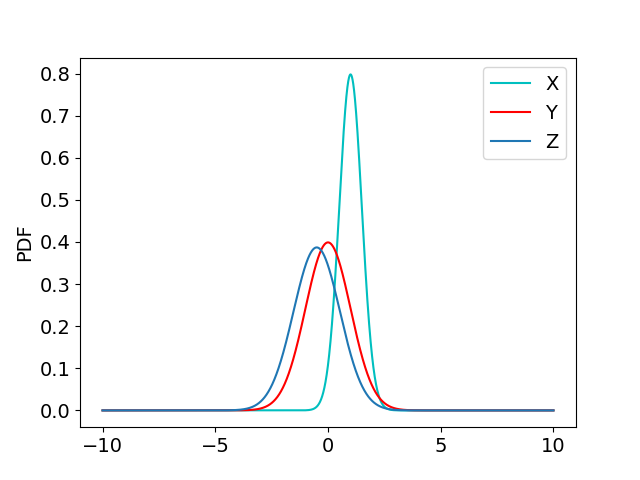

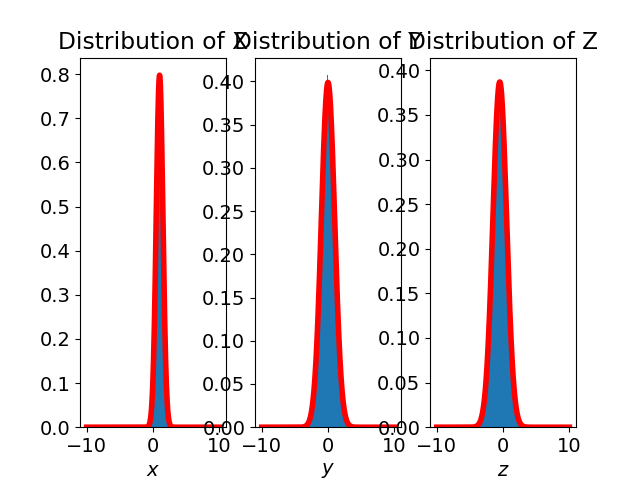

In [10]:
plot_x_y_z(100000, -0.5)

### Gaussian Process ($a$ can vary (but is not a random variable))

The above examples show what happens for _fixed $a$_. However, what happens if we treat $a$ as an _independent_ (deterministic) variable? In this case $Z(a)$ becomes a random _function._ In the previous example this function is linear
$$Z(a) = aX + Y$$  
but we can come up with more complex forms as well. For example,
$$Z(a) = (a + a^2)X + Y.$$

The way to look at this is as a two step process:

1. Sample $X$ and $Y$
2. Now $Z(a)$ can be viewed as a _sample of a function_. In the linear case sampling $X$ and $Y$ chooses a "random" slope and offset.

Indeed $Z(a)$ is a special type of random function --- it is whats called a **Gaussian Process.**

**Definition:** A Gaussian process $Z(a)$ is a random function where any subset $\{a_1, a_2, \ldots, a_d\}$ the joint distribution of $\{Z(a_1), Z(a_2), \ldots, Z(a_d)\}$ is multivariate Gaussian.

After this example you should try to determine

1. What is the covariance of $Z$ between any two points, i.e., what is $cov(Z(a_1), Z(a_2))$
2. What is the "mean" function $m(a) = \mathbb{E}\left[Z(a)\right] = a \mathbb{E}[X] + \mathbb{E}[Y]$

Lets take a look...

If ($Z = XY$), then this is not a Gaussian, also you have to be more careful when computing $\mathbb{E}[Z]$


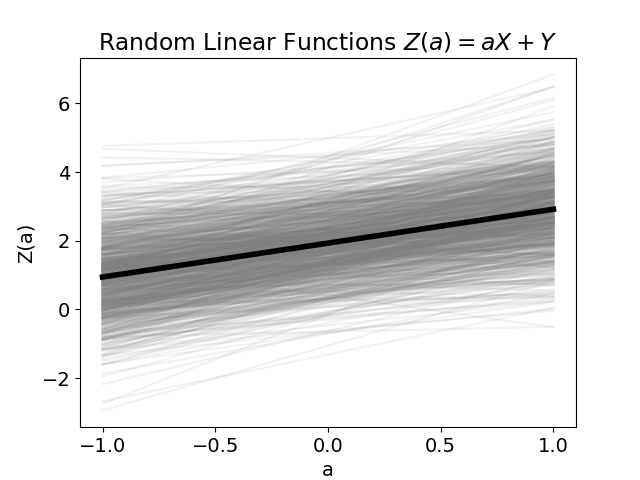

In [11]:
def sample_linear_functions(avec: np.ndarray, nsamples: int) -> np.ndarray:
    """ Sample random functions and plot them."""

    n = avec.shape[0]

    # generate samples of x and y
    samples_x = np.random.randn(nsamples) * 0.5 + 1.0  # slope
    samples_y = np.random.randn(nsamples) + 2.0        # offset

    # each sample corresponds to function, so we loop over samples and plot the functions
    samples_z = np.zeros((n, nsamples))
    plt.figure()
    for ii in range(nsamples):
        samples_z[:, ii] = avec * samples_x[ii] + samples_y[ii]
        plt.plot(avec, samples_z[:, ii], '-', color='grey', alpha=0.1)

    # We can also plot the mean (why does the below give the mean?)
    plt.plot(avec, avec*np.mean(samples_x) +
             np.mean(samples_y), '-', color='black', lw=4)
    plt.title("Random Linear Functions $Z(a) = aX + Y$")
    plt.xlabel("a")
    plt.ylabel("Z(a)")
    plt.show()
    return samples_z


samples_z = sample_linear_functions(np.linspace(-1, 1, 100), 1000)

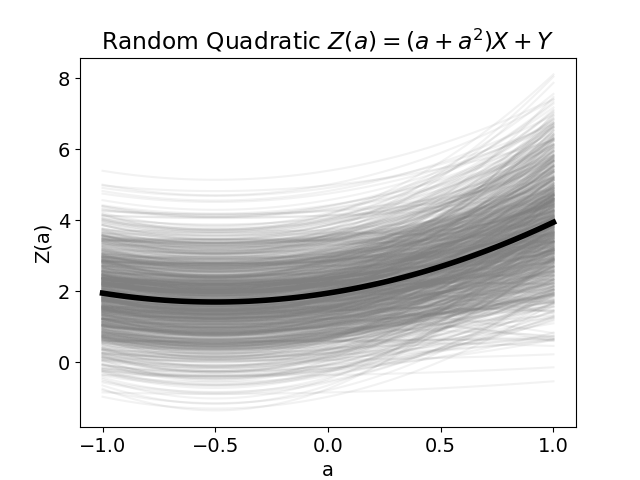

In [12]:
def sample_quadratic_functions(avec: np.ndarray, nsamples: int) -> None:
    """ Sample random functions and plot them """

    # generate samples of x and y
    samples_x = np.random.randn(nsamples) * 0.5 + 1.0  # slope
    samples_y = np.random.randn(nsamples) + 2.0        # offset
    # each sample corresponds to function, so we loop over samples and plot the functions
    plt.figure()
    for ii in range(nsamples):
        plt.plot(avec, (avec + avec**2) *
                 samples_x[ii] + samples_y[ii], '-', color='grey', alpha=0.1)

    # We can also plot the mean (why does the below give the mean?)
    plt.plot(avec, (avec + avec**2) * np.mean(samples_x) +
             np.mean(samples_y), '-', color='black', lw=4)
    plt.title("Random Quadratic $Z(a) = (a + a^2)X + Y$")
    plt.xlabel("a")
    plt.ylabel("Z(a)")
    plt.show()


sample_quadratic_functions(np.linspace(-1, 1, 100), 1000)

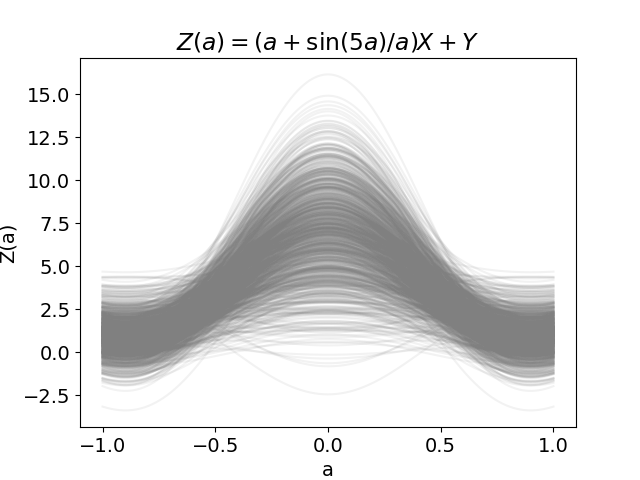

In [13]:
def sample_arbitrary_functions(avec: np.ndarray, nsamples: int) -> None:
    """ Sample some arbitrary functions and plot them."""

    # generate samples of x and y
    samples_x = np.random.randn(nsamples) * 0.5 + 1.0  # slope
    samples_y = np.random.randn(nsamples) + 2.0        # offset
    # each sample corresponds to function, so we loop over samples and plot the functions
    plt.figure()
    for ii in range(nsamples):
        plt.plot(avec, np.sin(5*avec)/avec *
                 samples_x[ii] + samples_y[ii], '-', color='grey', alpha=0.1)

        # plt.plot(avec, np.tan(5*avec) * samples_x[ii] + samples_y[ii], '-', color='grey', alpha=0.1)

        # plt.plot(avec, np.exp(-0.5 * ((avec - 0.25)/0.1)**2) * samples_x[ii] + samples_y[ii], '-', color='grey', alpha=0.1)

    # We can also plot the mean (why does the below give the mean?)
    # plt.plot(avec, np.sin(5*avec)/avec * np.mean(samples_x) + np.mean(samples_y), '-', color='black', lw=4)
    plt.title("$Z(a) = (a + \\sin(5a)/a)X + Y$")
    # plt.title(r'$Z(a) = \exp(-0.5 (a-0.25)^2/(0.1)^2) * X + Y$')
    plt.xlabel("a")
    plt.ylabel("Z(a)")
    plt.show()


sample_arbitrary_functions(np.linspace(-1, 1, 10000), 1000)